In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner
from IPython.display import Latex
import sys
import warnings
import tqdm


plt.rcParams['image.cmap'] = 'Blues'
warnings.filterwarnings("ignore")

imageFile = "../fit/agn.fits"
imageAGN = fits.getdata(imageFile)

epsf = fits.getdata("../psfConstruction/epsf2.fits")

In [2]:
def find_highest_indices(arr):
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices


def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim,
                 PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim, sigma_lim, Iss_lim, rss_lim):
    """create galaxy model for ML fit
        including: ps: 1 psf + 1 sersic
                   psps: 2 psf + 2 sersic"""

    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    
    psf = {'I_tot' : Itot}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}

    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_sersic0 = {'X0': [Xss0,Xlim[0],Xlim[1]], 'Y0': [Yss0,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xlim[0],Xlim[1]], 'Y0': [Yss1,Ylim[0],Ylim[1]], 
                   'function_list': [sersic_dict]}
    
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict, sersic_dict]}

    
    model_dict_ps_1c = {'function_sets': [funcset_dict_psfser0]}
    model_dict_psps_1c = {'function_sets': [funcset_dict_psfser0,funcset_dict_psfser1]}
    
    model_dict_ps_2c = {'function_sets': [funcset_dict_psf0,funcset_dict_sersic0]}
    model_dict_psps_2c = {'function_sets': [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1]}
    
    model_ps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_1c)
    model_psps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_1c)
    model_ps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_2c)
    model_psps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_2c)
    return model_ps1c, model_psps1c, model_ps2c, model_psps2c



def doFit(models,epsf): 
    """do fit with data using PSF oversampled by factor of 4 over whole image
       return fitters"""
    fitters = []
    # oversamped PSF
    psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
    osampleList = [psfOsamp]
    for i in tqdm.tqdm(range(len(models)), desc="Fitting Models"):
        imfit_fitter = pyimfit.Imfit(models[i],psf=epsf)
        imfit_fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
        imfit_fitter.doFit()
        fitters.append(imfit_fitter)
    return fitters



        
        
starpos = find_highest_indices(imageAGN)
center = (starpos[0]+starpos[1])/2
Imax = imageAGN.max()
itot=epsf.sum()


X0=starpos[0][0]
Y0=starpos[0][1]
X1=starpos[1][0]
Y1=starpos[1][1] 
Xss0=starpos[0][0]
Yss0=starpos[0][1]
Xss1=starpos[1][0]
Yss1=starpos[1][1]
Xlim=[0,100]
Ylim=[0,100]
PA_ss=200
ell_ss=0.1
n_ss=1
I_ss=1
r_ss=20
PA_lim=[0,360]
ell_lim=[0.0,1.0]
I_lim=[0,Imax]
sigma_lim=[0,15]
Iss_lim=[0,Imax]
rss_lim=[0,100]

Itot=130

psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
osampleList = [psfOsamp]

PsfOversampling: starting initialization...
141
PsfOversampling: done.


In [3]:
sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}

psf = {'I_tot' : Itot}
psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}

funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict]}
funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict]}
funcset_dict_sersic0 = {'X0': [Xss0,Xlim[0],Xlim[1]], 'Y0': [Yss0,Ylim[0],Ylim[1]], 
               'function_list': [sersic_dict]}
funcset_dict_sersic1 = {'X0': [Xss1,Xlim[0],Xlim[1]], 'Y0': [Yss1,Ylim[0],Ylim[1]], 
               'function_list': [sersic_dict]}

funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict, sersic_dict]}
funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                'function_list': [psf_dict, sersic_dict]}


model_dict_ps_1c = {'function_sets': [funcset_dict_psfser0]}
model_dict_psps_1c = {'function_sets': [funcset_dict_psfser0,funcset_dict_psfser1]}

model_dict_ps_2c = {'function_sets': [funcset_dict_psf0,funcset_dict_sersic0]}
model_dict_psps_2c = {'function_sets': [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1]}

model_ps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_1c)
model_psps1c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_1c)
model_ps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_ps_2c)
model_psps2c = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict_psps_2c)


In [4]:
modeldict = {'function_sets':[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1]}
model = pyimfit.ModelDescription.dict_to_ModelDescription(modeldict)
fitter = pyimfit.Imfit(model,psf=epsf)
fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
fitter.doFit()

            aic: 48668939135.436554
            bic: 48668939265.15415
   fitConverged: True
        fitStat: 48668939099.36803
 fitStatReduced: 4875670.116145865
          nIter: 3
      paramErrs: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.22393971e-07,
       8.92590872e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.24493886e-04, 0.00000000e+00, 6.78327887e-06,
       5.01229461e-05, 1.40435686e-04, 1.86460549e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
         params: array([ 5.96164075e+01,  4.40187590e+01,  7.59751332e+02,  4.80000026e+01,
        5.19999979e+01, -6.73367311e+01,  8.08811063e+01,  5.61426678e+01,
        2.00000000e+02,  1.00000000e-01,  1.00000000e+00,  1.00019009e+00,
        1.99982995e+01,  4.80015516e+01,  0.00000000e+00,  2.00124113e+02,
        1.00000000e-01,  1.00000000e+00,  1.00000000e+00,  2.00000000e+01])
     solverName: 'LM'

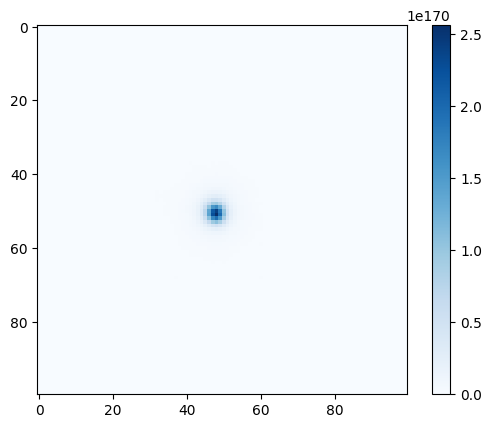

In [21]:
plt.imshow(fitter.getModelImage(newParameters = [ 60.,  45., 6700000.,  49.,  52., 67000000.,  81.,  57., 201.,   1.,   1.,
         2.,  2,  49.,   50., 201.,   1.,   1.,   1.,  2.]))
plt.colorbar();

In [5]:
bf = fitter.getFitResult().params
names = fitter.numberedParameterNames
for i in range(len(bf)):
    print(names[i], bf[i])

X0_1 59.61640750098246
Y0_1 44.01875900875978
I_tot_1 759.7513319180212
X0_2 48.00000262068689
Y0_2 51.99999793578321
I_tot_2 -67.33673105278203
X0_3 80.8811063289937
Y0_3 56.14266776232339
PA_3 200.0000001978908
ell_bulge_3 0.10000000001204559
n_3 1.0
I_e_3 1.0001900922209142
r_e_3 19.998299459605732
X0_4 48.00155163518655
Y0_4 0.0
PA_4 200.12411334011531
ell_bulge_4 0.1
n_4 1.0
I_e_4 1.0
r_e_4 20.0


In [7]:
np. set_printoptions(suppress=True    )
np.ceil(bf)

array([ 60.,  45., 760.,  49.,  52., -67.,  81.,  57., 201.,   1.,   1.,
         2.,  20.,  49.,   0., 201.,   1.,   1.,   1.,  20.])

In [5]:
np. set_printoptions(suppress=True    )
np.ceil(np.array([4.94873561e+01, 5.67360988e+01, 1.37318644e+03, 6.59741105e+01,
       3.77094930e-01, 1.00000000e+00, 2.29771397e+01, 1.09635638e+01]))

array([  50.,   57., 1374.,   66.,    1.,    1.,   23.,   11.])

In [7]:
np. set_printoptions(suppress=True    )
np.ceil(np.array([4.94873393e+01, 5.67361124e+01, 2.68297115e+04, 2.45974246e+02,
       3.77093423e-01, 1.00000000e+00, 2.29769167e+01, 1.09636072e+01]))

array([   50.,    57., 26830.,   246.,     1.,     1.,    23.,    11.])